In [1]:
import os
os.chdir("../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import scanpy as sc
import numpy as np
import surgeon

Using TensorFlow backend.


In [5]:
sc.settings.set_figure_params(dpi=200)

In [6]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas CelSeq2", "Pancreas SS2"]
target_cell_types = ['Pancreas Alpha', 'Pancreas Gamma']

In [7]:
sc.settings.figdir = "./results/outofsample/pancreas_alpha+gamma/"

# Loading 5 Pancreas datasets and data preparation

In [8]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [9]:
batch_colors = ['#023fa5', '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784']

In [10]:
adata.uns[f'{condition_key}_colors'] = batch_colors

## Number of cells in each batch

In [11]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [12]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'
    uns: 'study_colors'

In [13]:
adata_for_training = adata_for_training[~adata_for_training.obs[cell_type_key].isin(target_cell_types)]
adata_for_training

View of AnnData object with n_obs × n_vars = 7291 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'
    uns: 'study_colors'

In [14]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'
    uns: 'study_colors'

## Train/Test Split

In [15]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.8)

In [16]:
train_adata.shape, valid_adata.shape

((5832, 1000), (1459, 1000))

In [17]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

# Create & Train model with training data

In [18]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 64, 32],
                             n_conditions=n_conditions,
                             use_batchnorm=False,
                             lr=0.001,
                             alpha=0.0005,
                             beta=1000.0,
                             clip_value=100.0,
                             eta=1.0,
                             loss_fn='mse',
                             model_path=f"./models/OutOfSample/pancreas_alpha+gamma/Before/",
                             dropout_rate=0.1,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [19]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

## Training the network

In [20]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder,
              n_epochs=10000,
              batch_size=1024, 
              early_stop_limit=50,
              lr_reducer=40, 
              n_per_epoch=0,
              save=True,
              retrain=False,
              verbose=5)

Model has been successfully restored!


In [21]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [22]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [23]:
latent_adata = network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 7291 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [24]:
palette = ['#023fa5', '#bec1d4', '#bb7784']

In [25]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

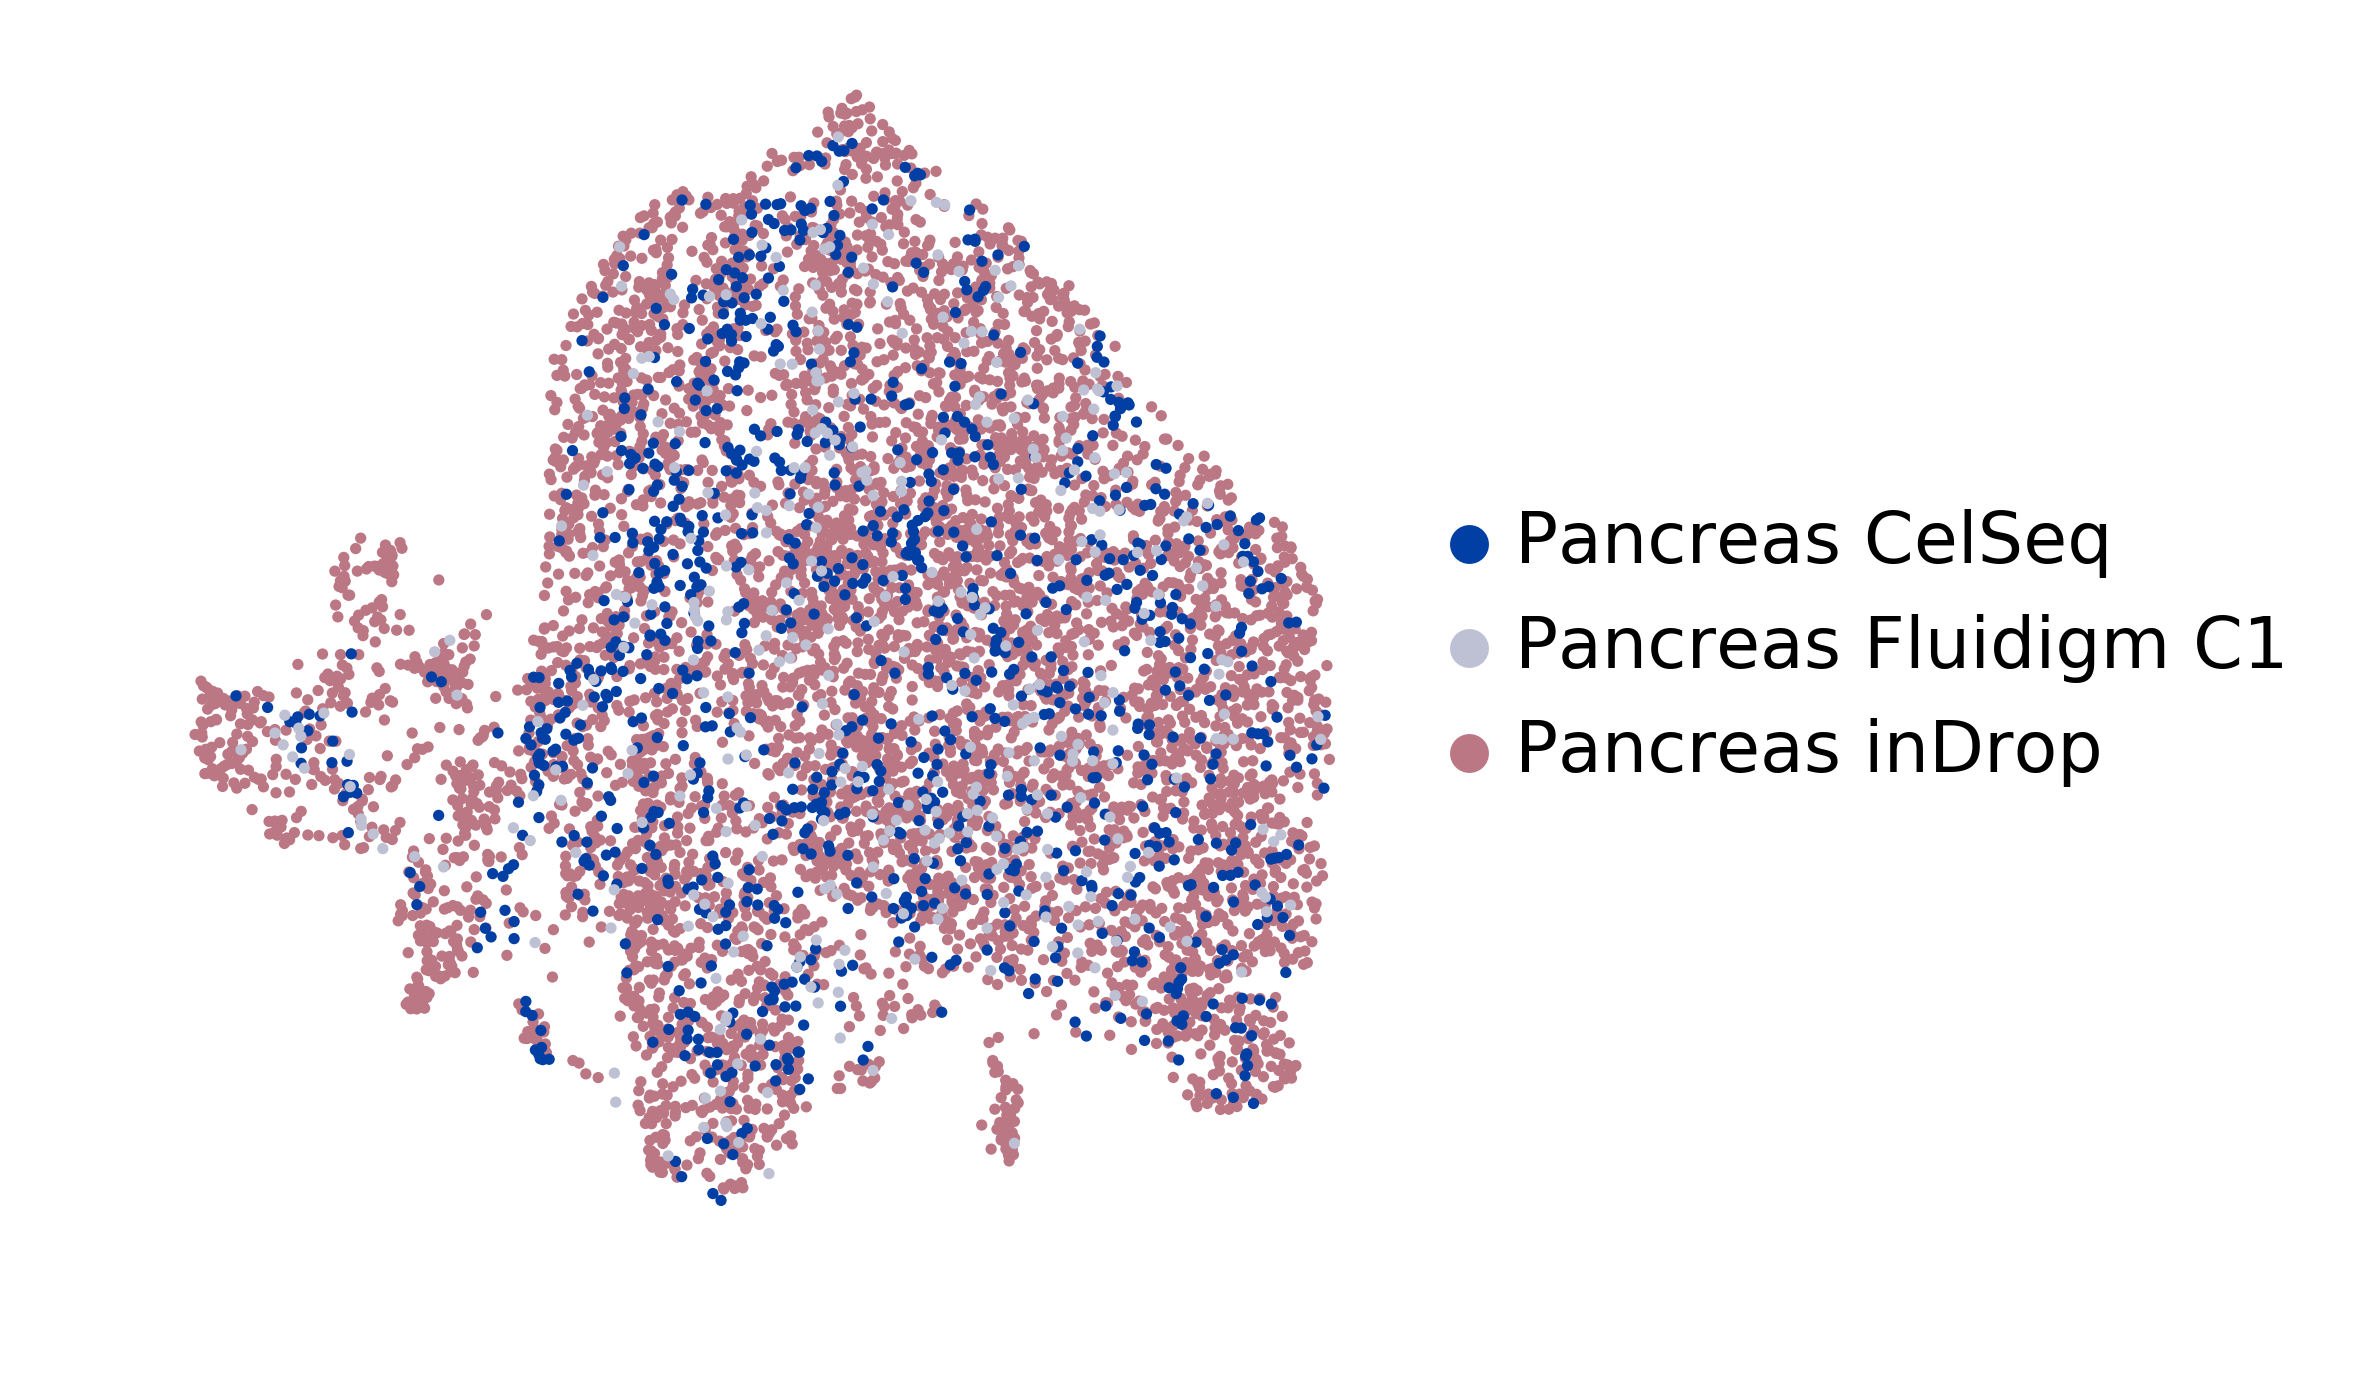

In [27]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_before.pdf", palette=palette)

In [28]:
palette = sc.pl.palettes.godsnot_102[:1] + sc.pl.palettes.godsnot_102[2:6] + sc.pl.palettes.godsnot_102[7:]

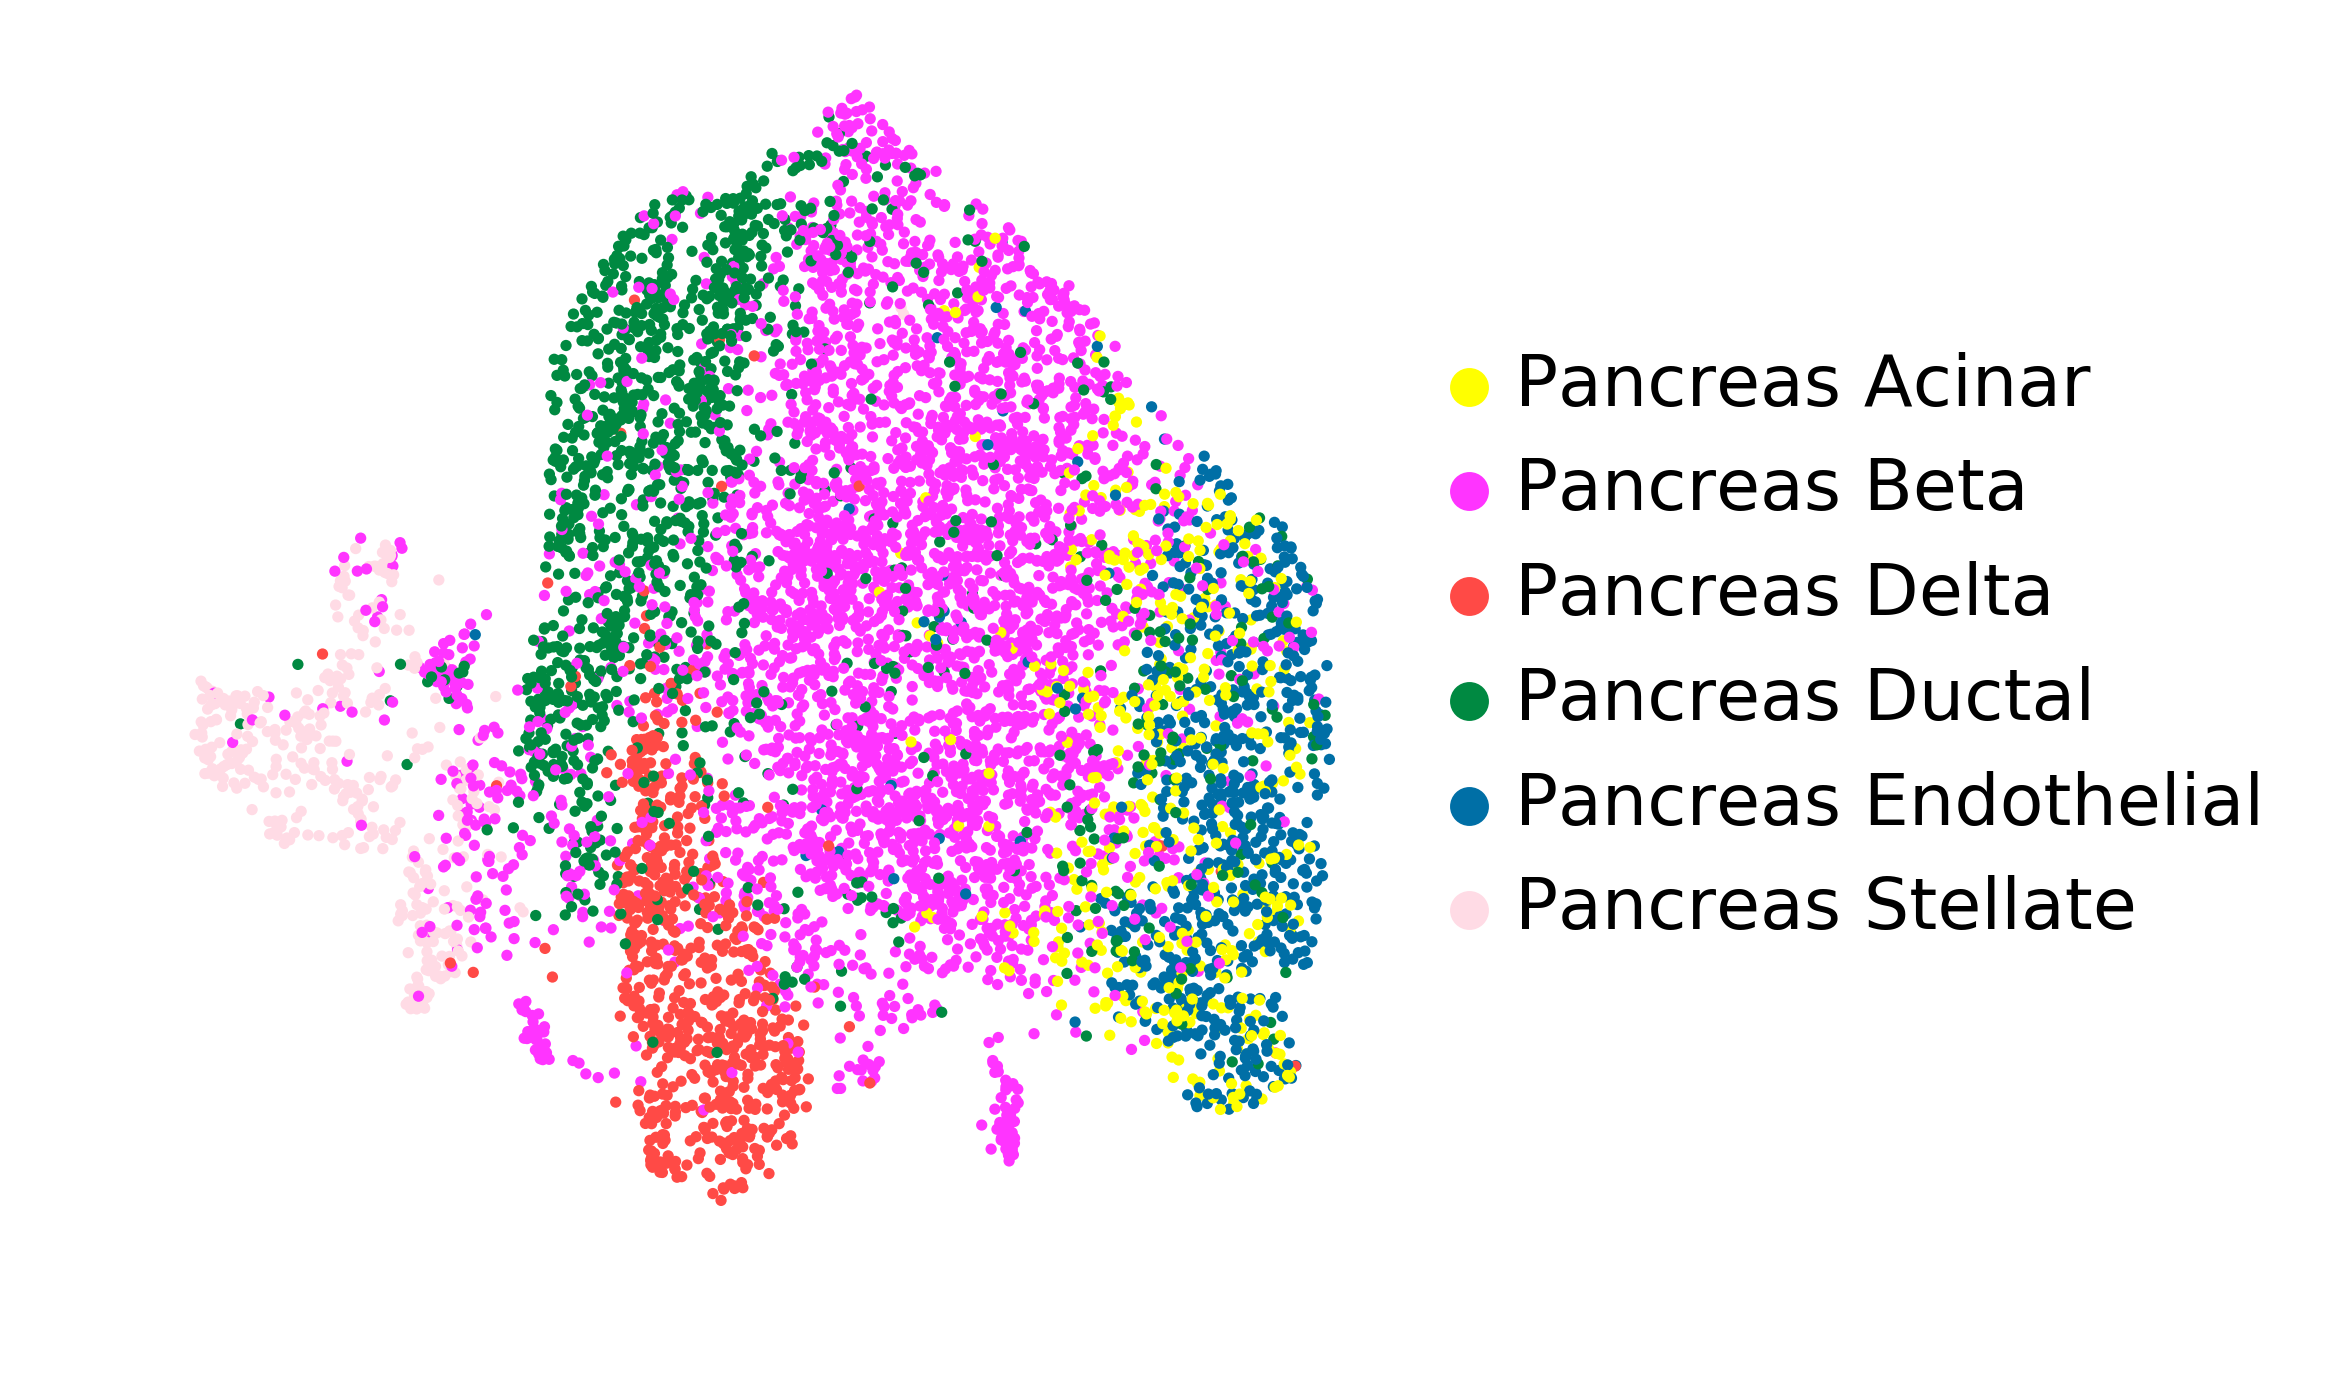

In [29]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_before.pdf", palette=palette)

# Perfroming architecture Surgery

In [30]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier',
                              freeze_expression_input=True,
                              freeze=True,
                              remove_dropout=False,
                              )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128640      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________

In [31]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas CelSeq2': 3,
 'Pancreas SS2': 4}

## Train with small new dataset containing out-of-sample condition

In [32]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.8)

In [33]:
train_adata.shape, valid_adata.shape

((4309, 1000), (1078, 1000))

In [34]:
new_network.model_path = f"./models/OutOfSample/Pancreas_alpha+gamma/after/"

In [35]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=False,
                  verbose=2)

Model has been successfully restored!


In [36]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(5387, 1)

In [37]:
latent_adata_after = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata_after

AnnData object with n_obs × n_vars = 5387 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [39]:
sc.pp.neighbors(latent_adata_after)
sc.tl.umap(latent_adata_after)

In [41]:
palette = ['#7d87b9', '#d6bcc0']

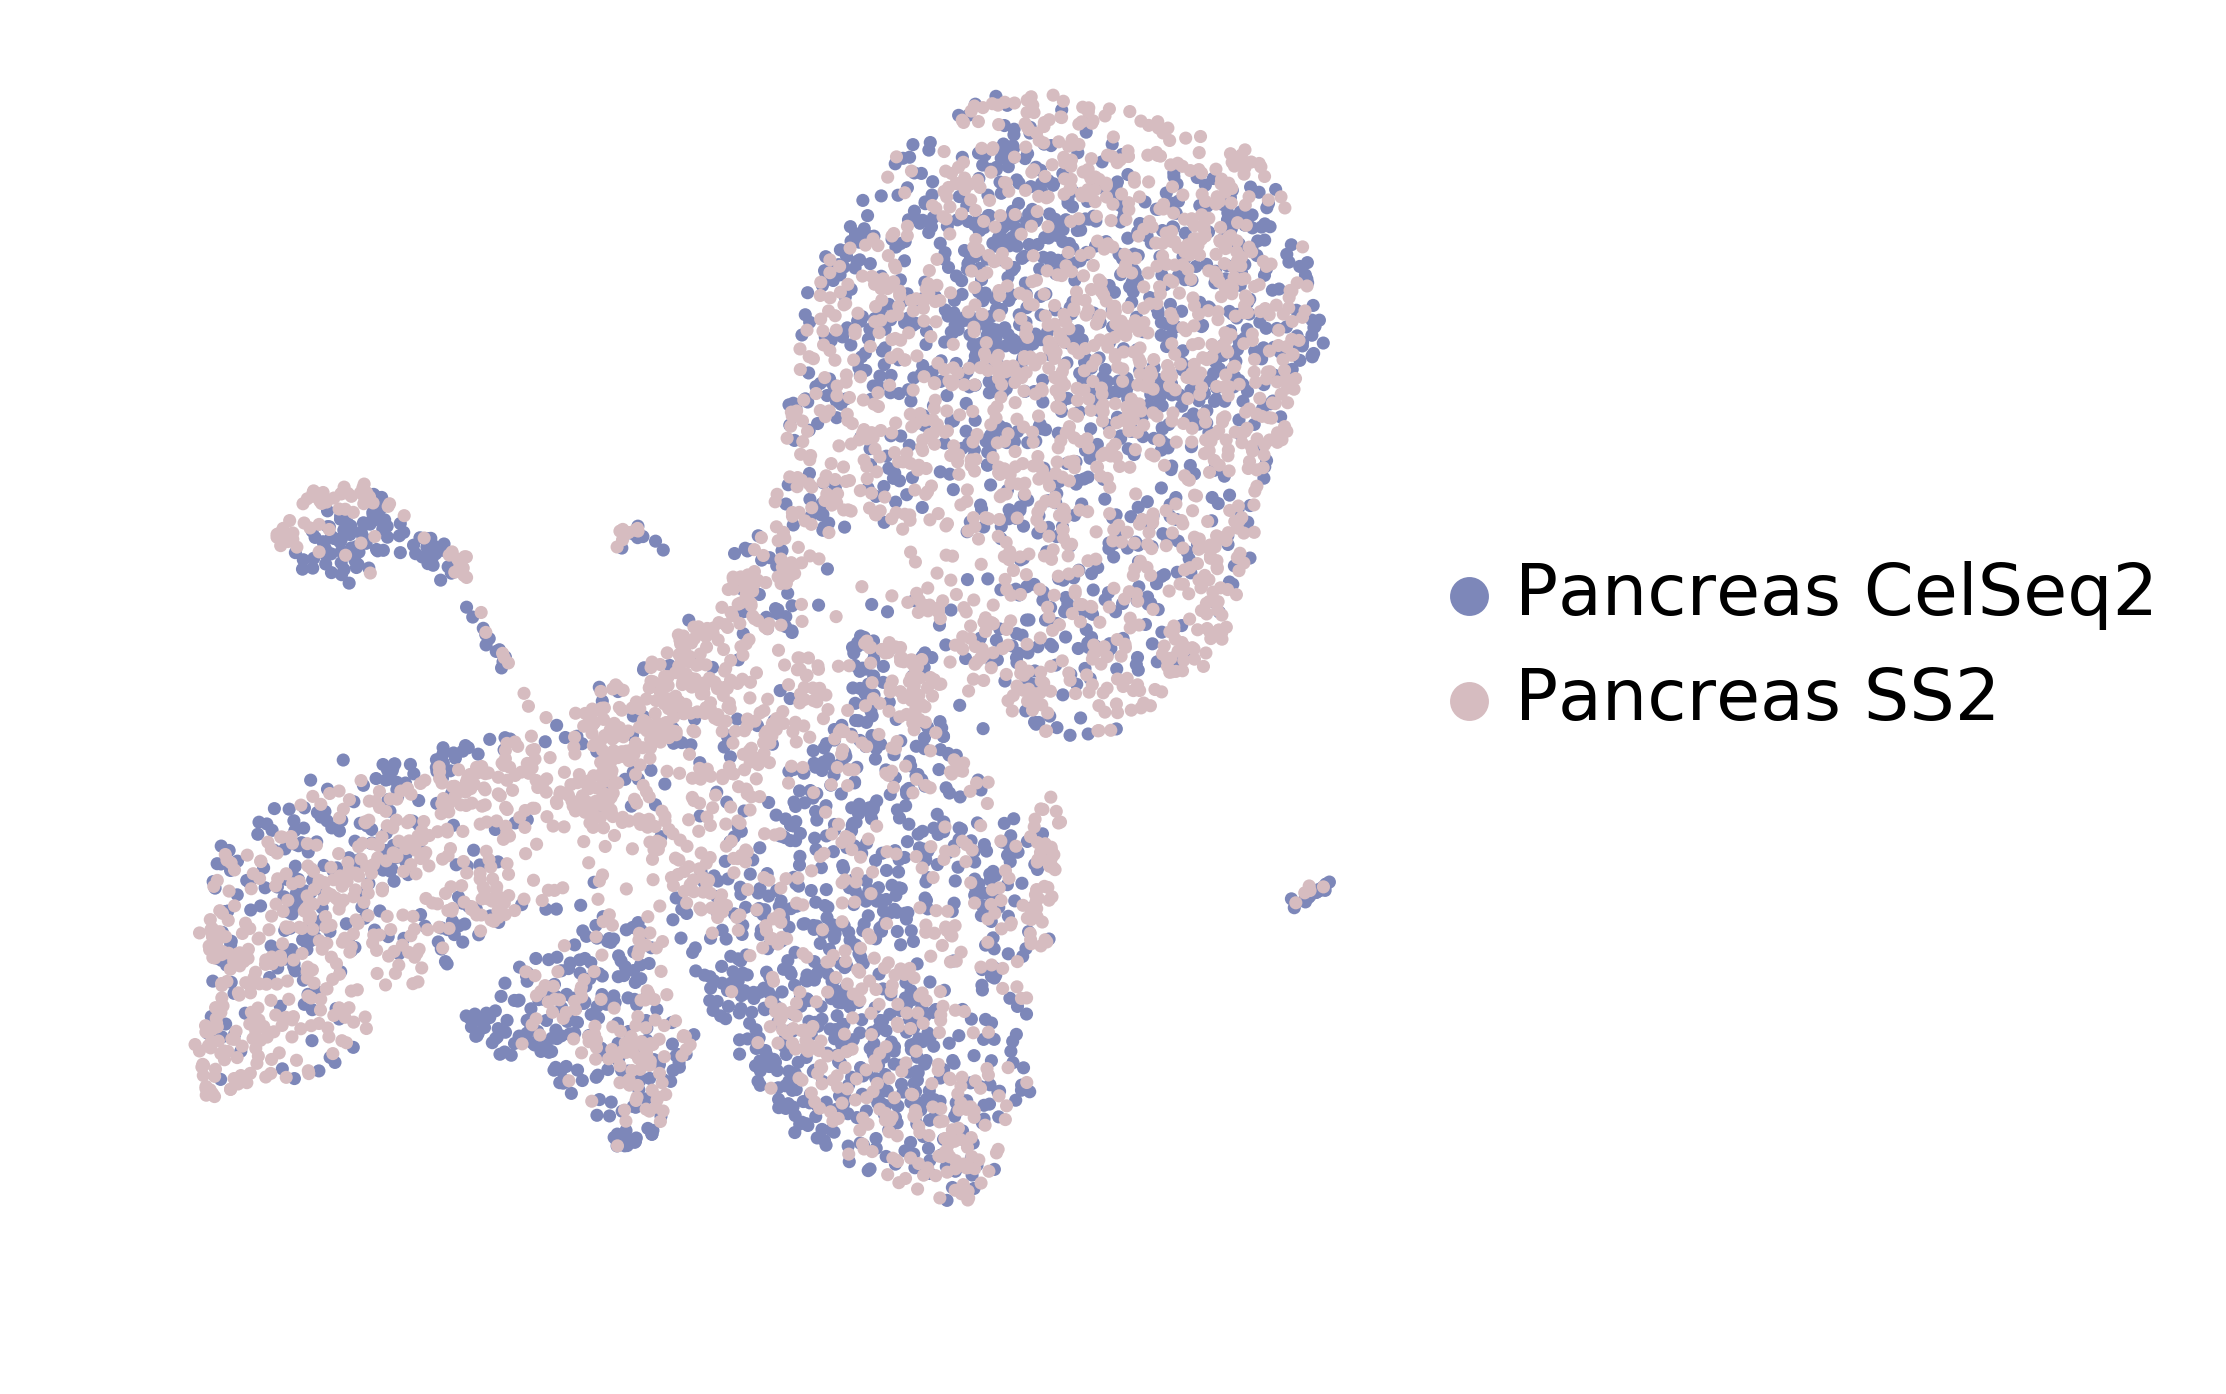

In [42]:
sc.pl.umap(latent_adata_after, color=[condition_key], frameon=False, title="", 
           save="_condition_out_of_sample_after.pdf", palette=palette)

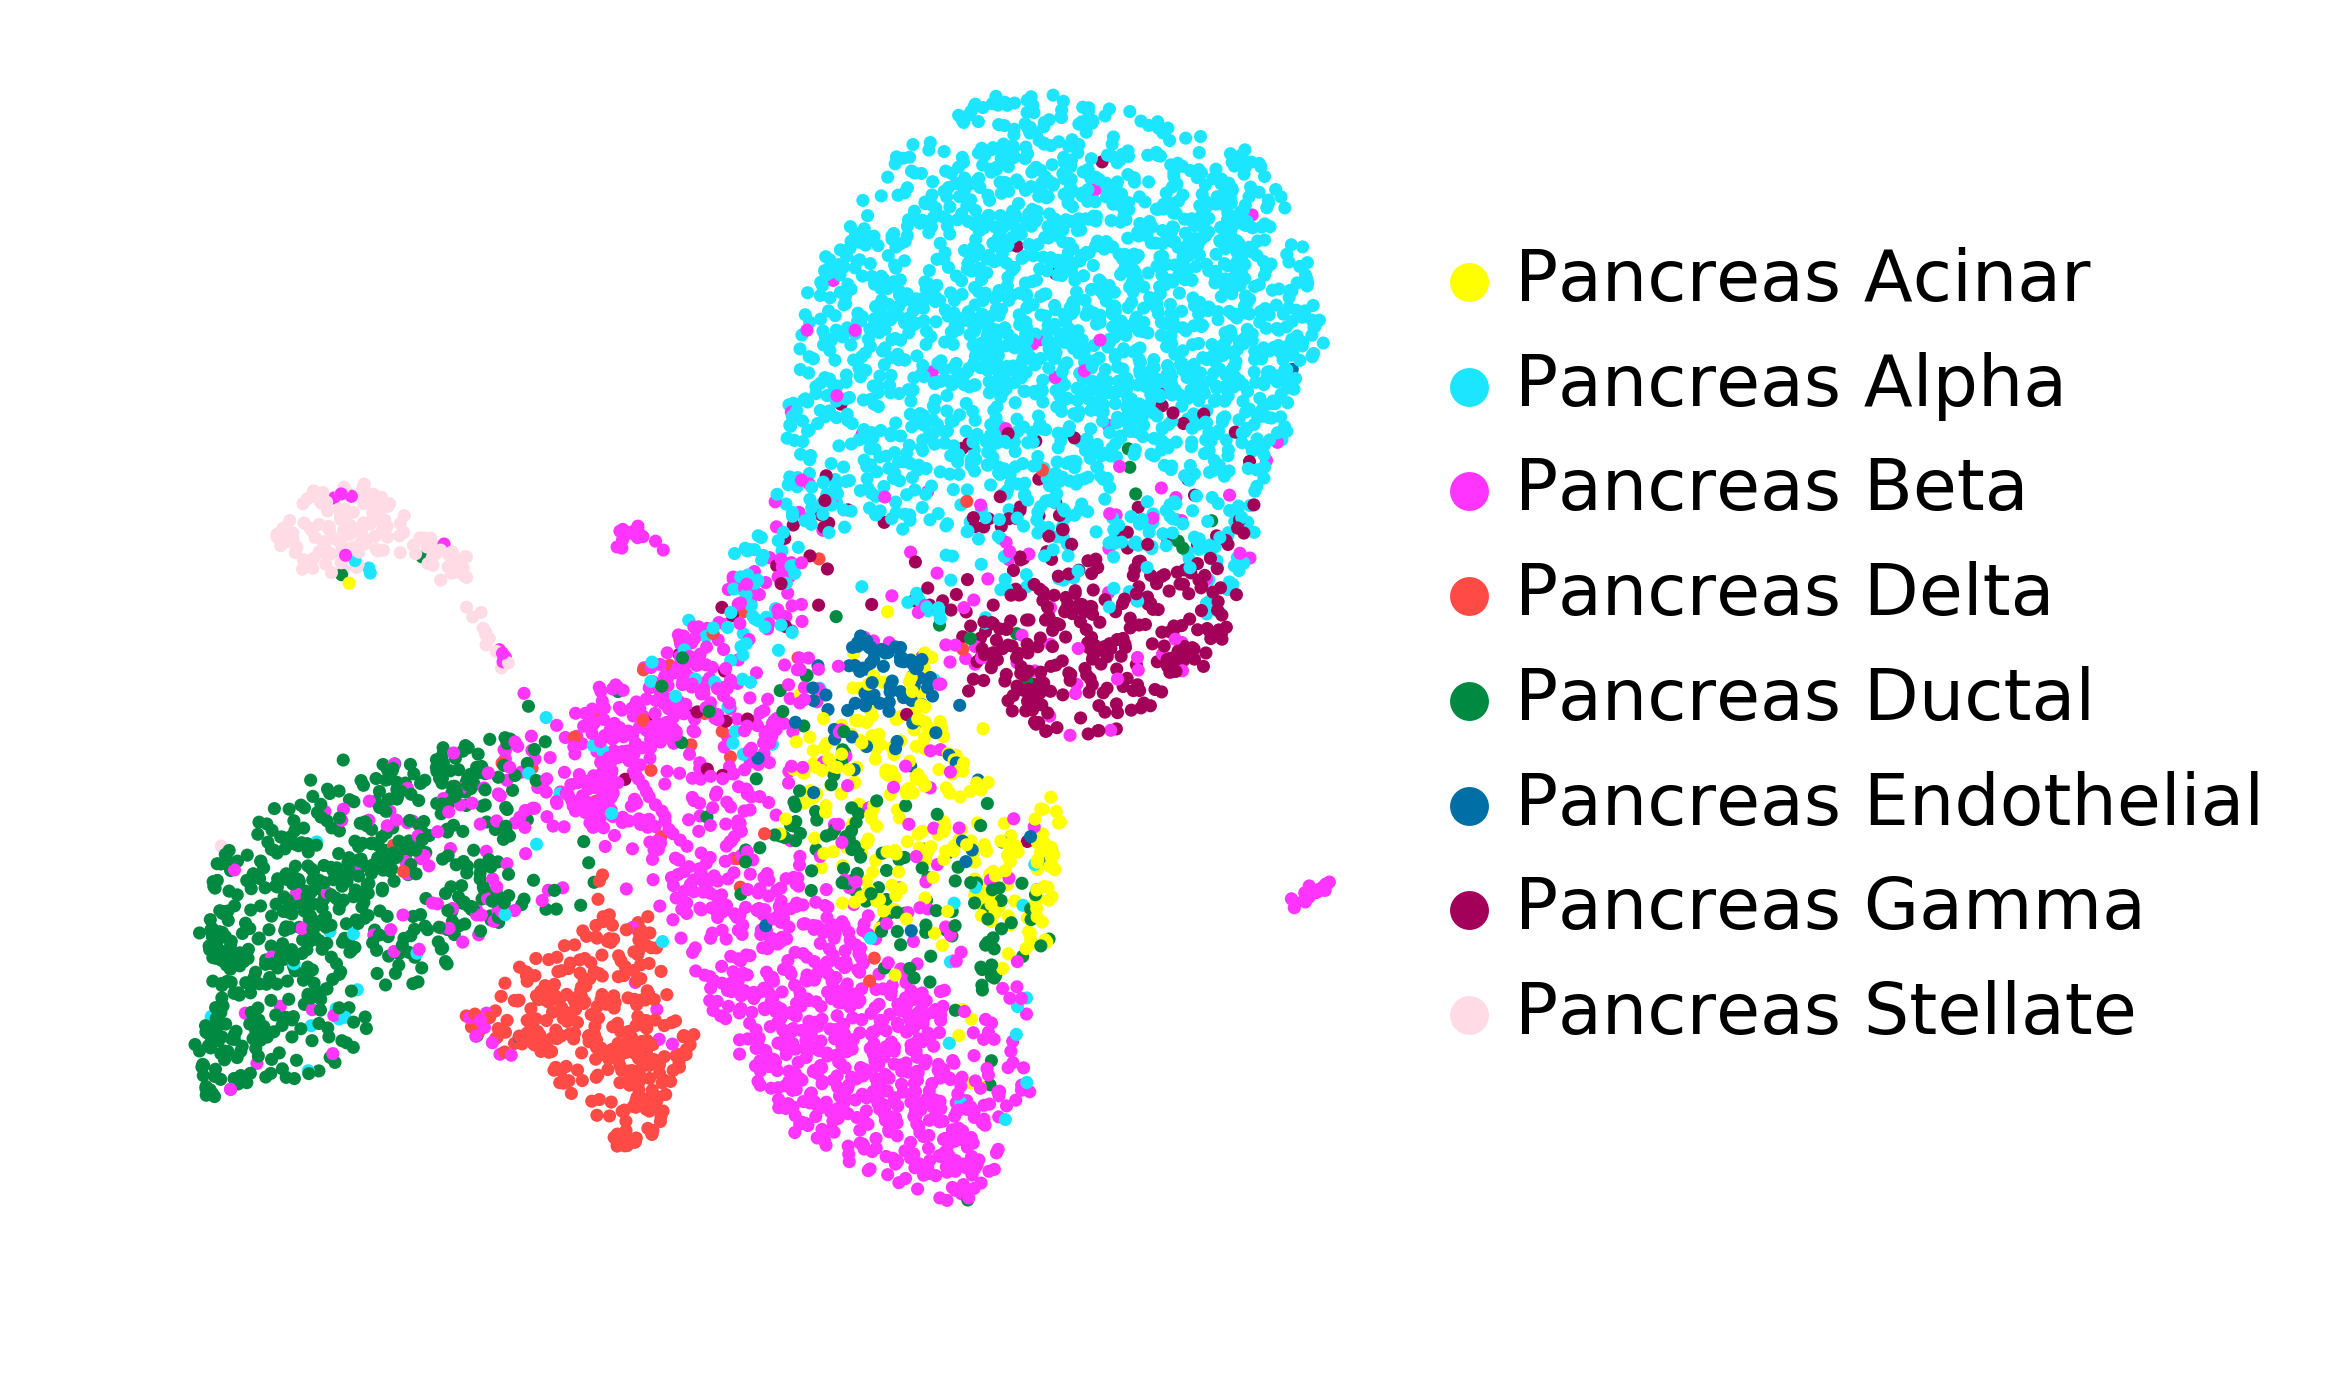

In [43]:
sc.pl.umap(latent_adata_after, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_out_of_sample_after.pdf", palette=sc.pl.palettes.godsnot_102)

# Let's see what has happened for the target cell types! :)

In [44]:
plot_adata = adata_for_training.concatenate(adata_out_of_sample)
plot_adata

AnnData object with n_obs × n_vars = 12678 × 1000 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [45]:
encoder_labels, _ = surgeon.utils.label_encoder(plot_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(12678, 1)

In [46]:
plot_adata.obs[cell_type_key].value_counts()

Pancreas Beta           5085
Pancreas Ductal         2104
Pancreas Alpha          1994
Pancreas Delta          1041
Pancreas Endothelial     836
Pancreas Acinar          713
Pancreas Stellate        561
Pancreas Gamma           344
Name: cell_type, dtype: int64

In [47]:
latent_adata = new_network.to_mmd_layer(plot_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 12678 × 32 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [48]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [49]:
palette = ['#023fa5', '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784']

... storing 'cell_type' as categorical
... storing 'study' as categorical


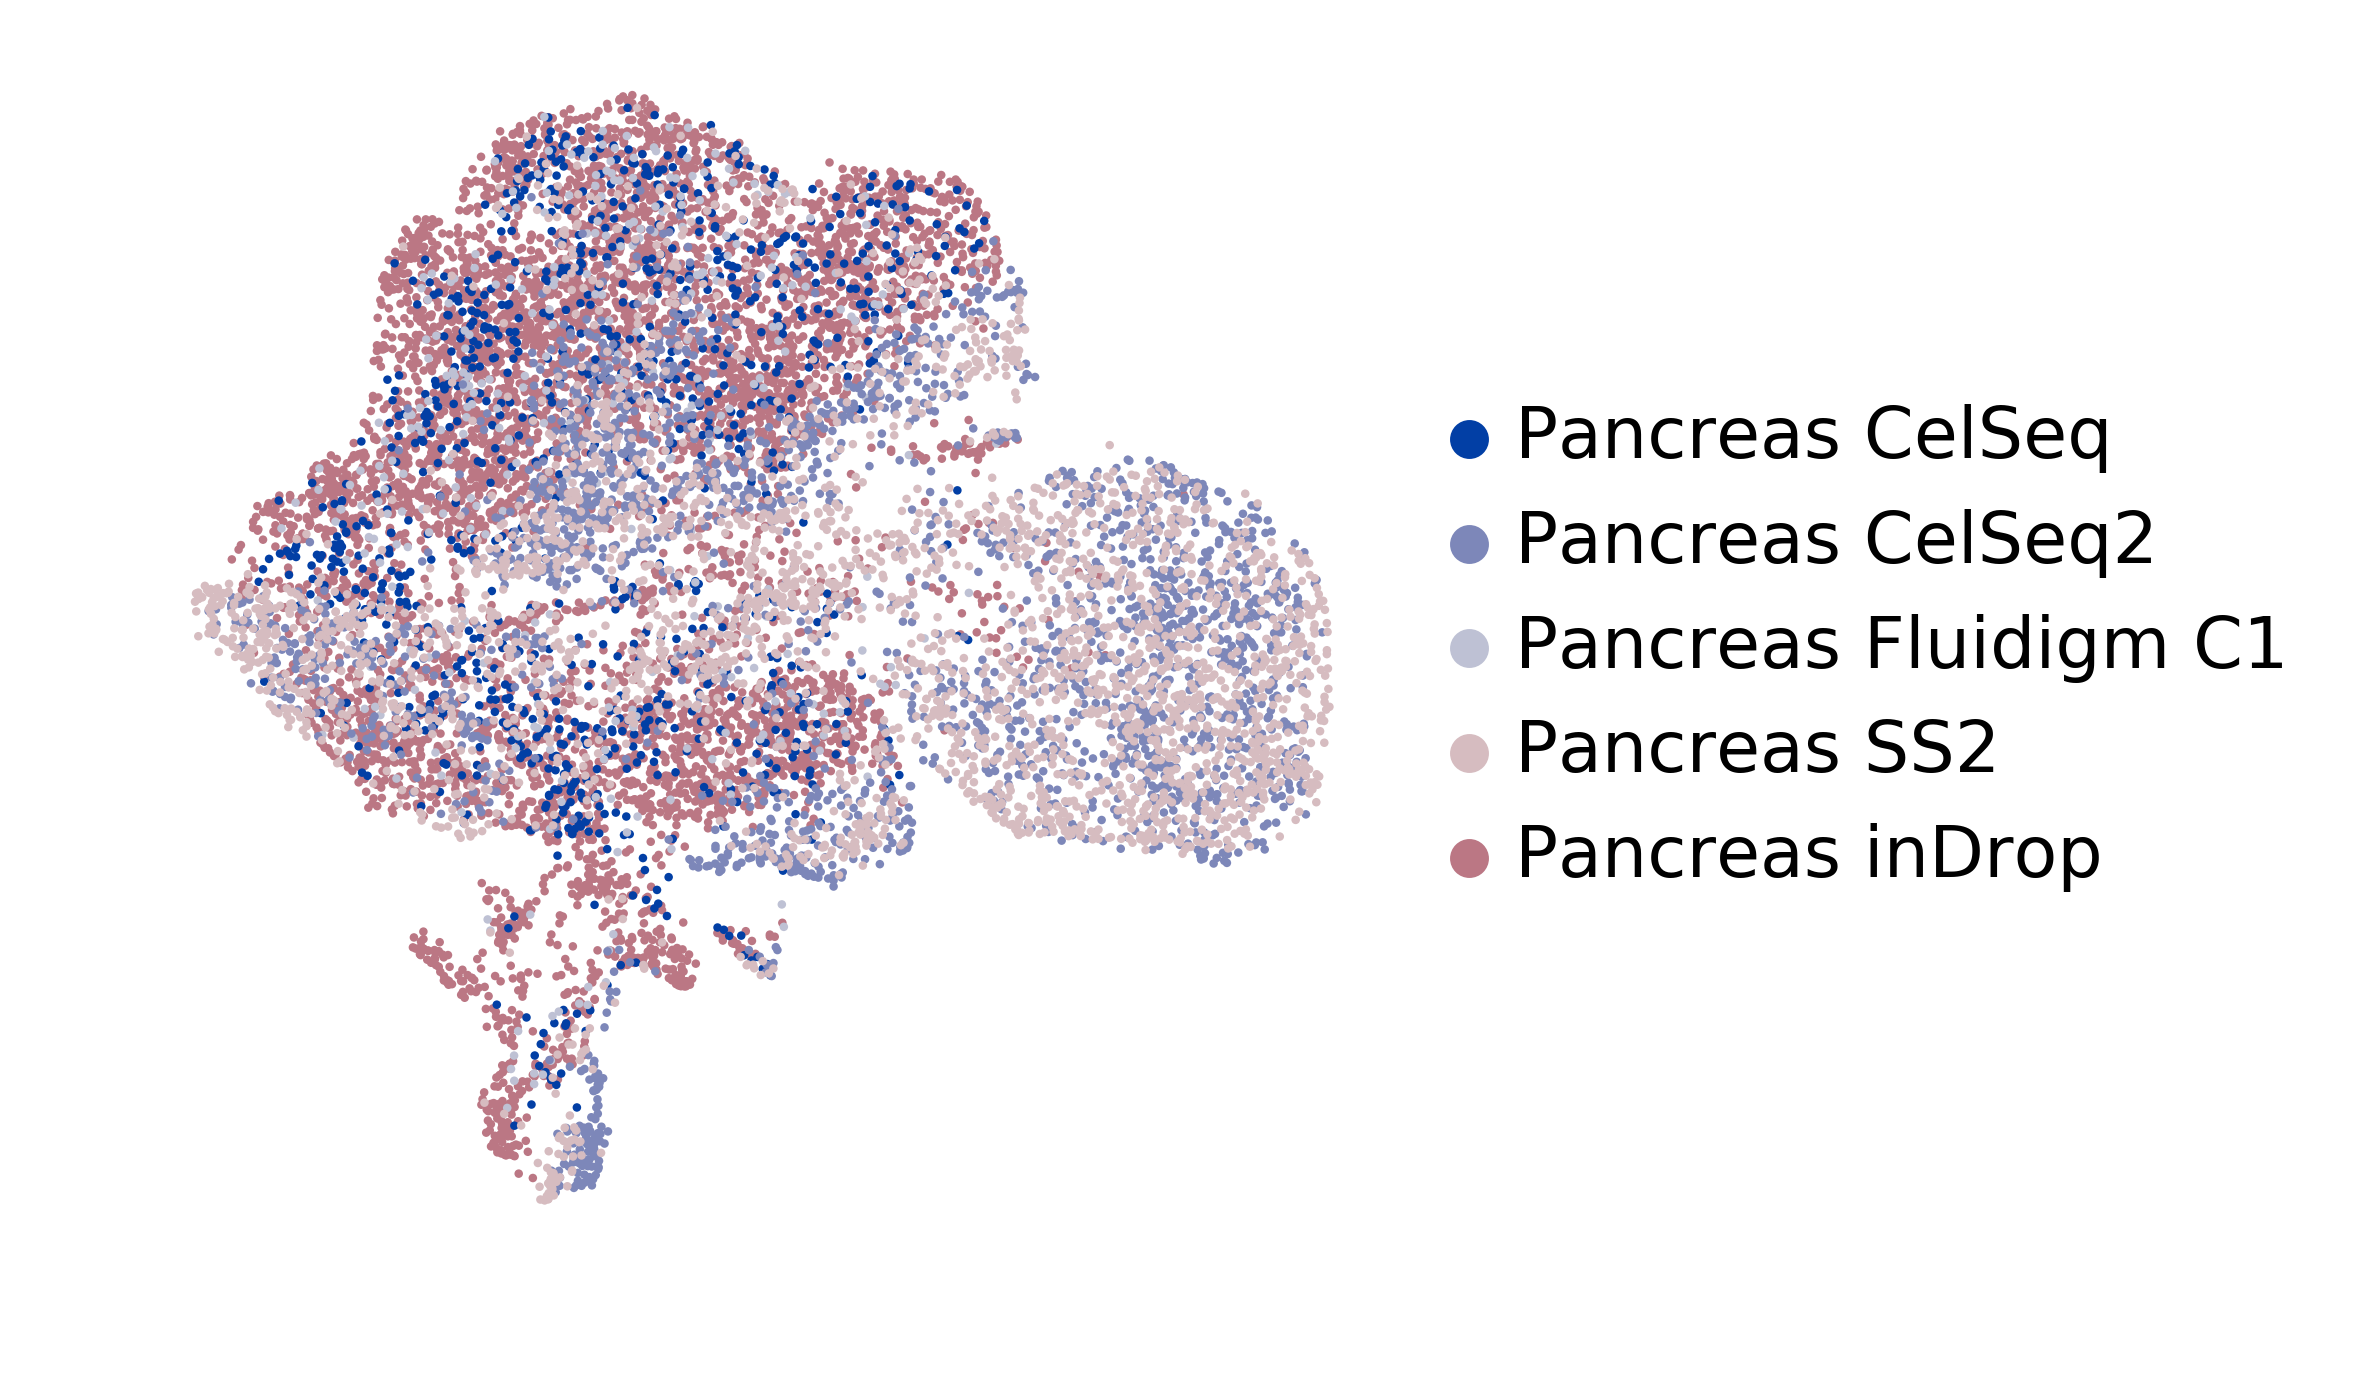

In [50]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_all_after.pdf", palette=palette)

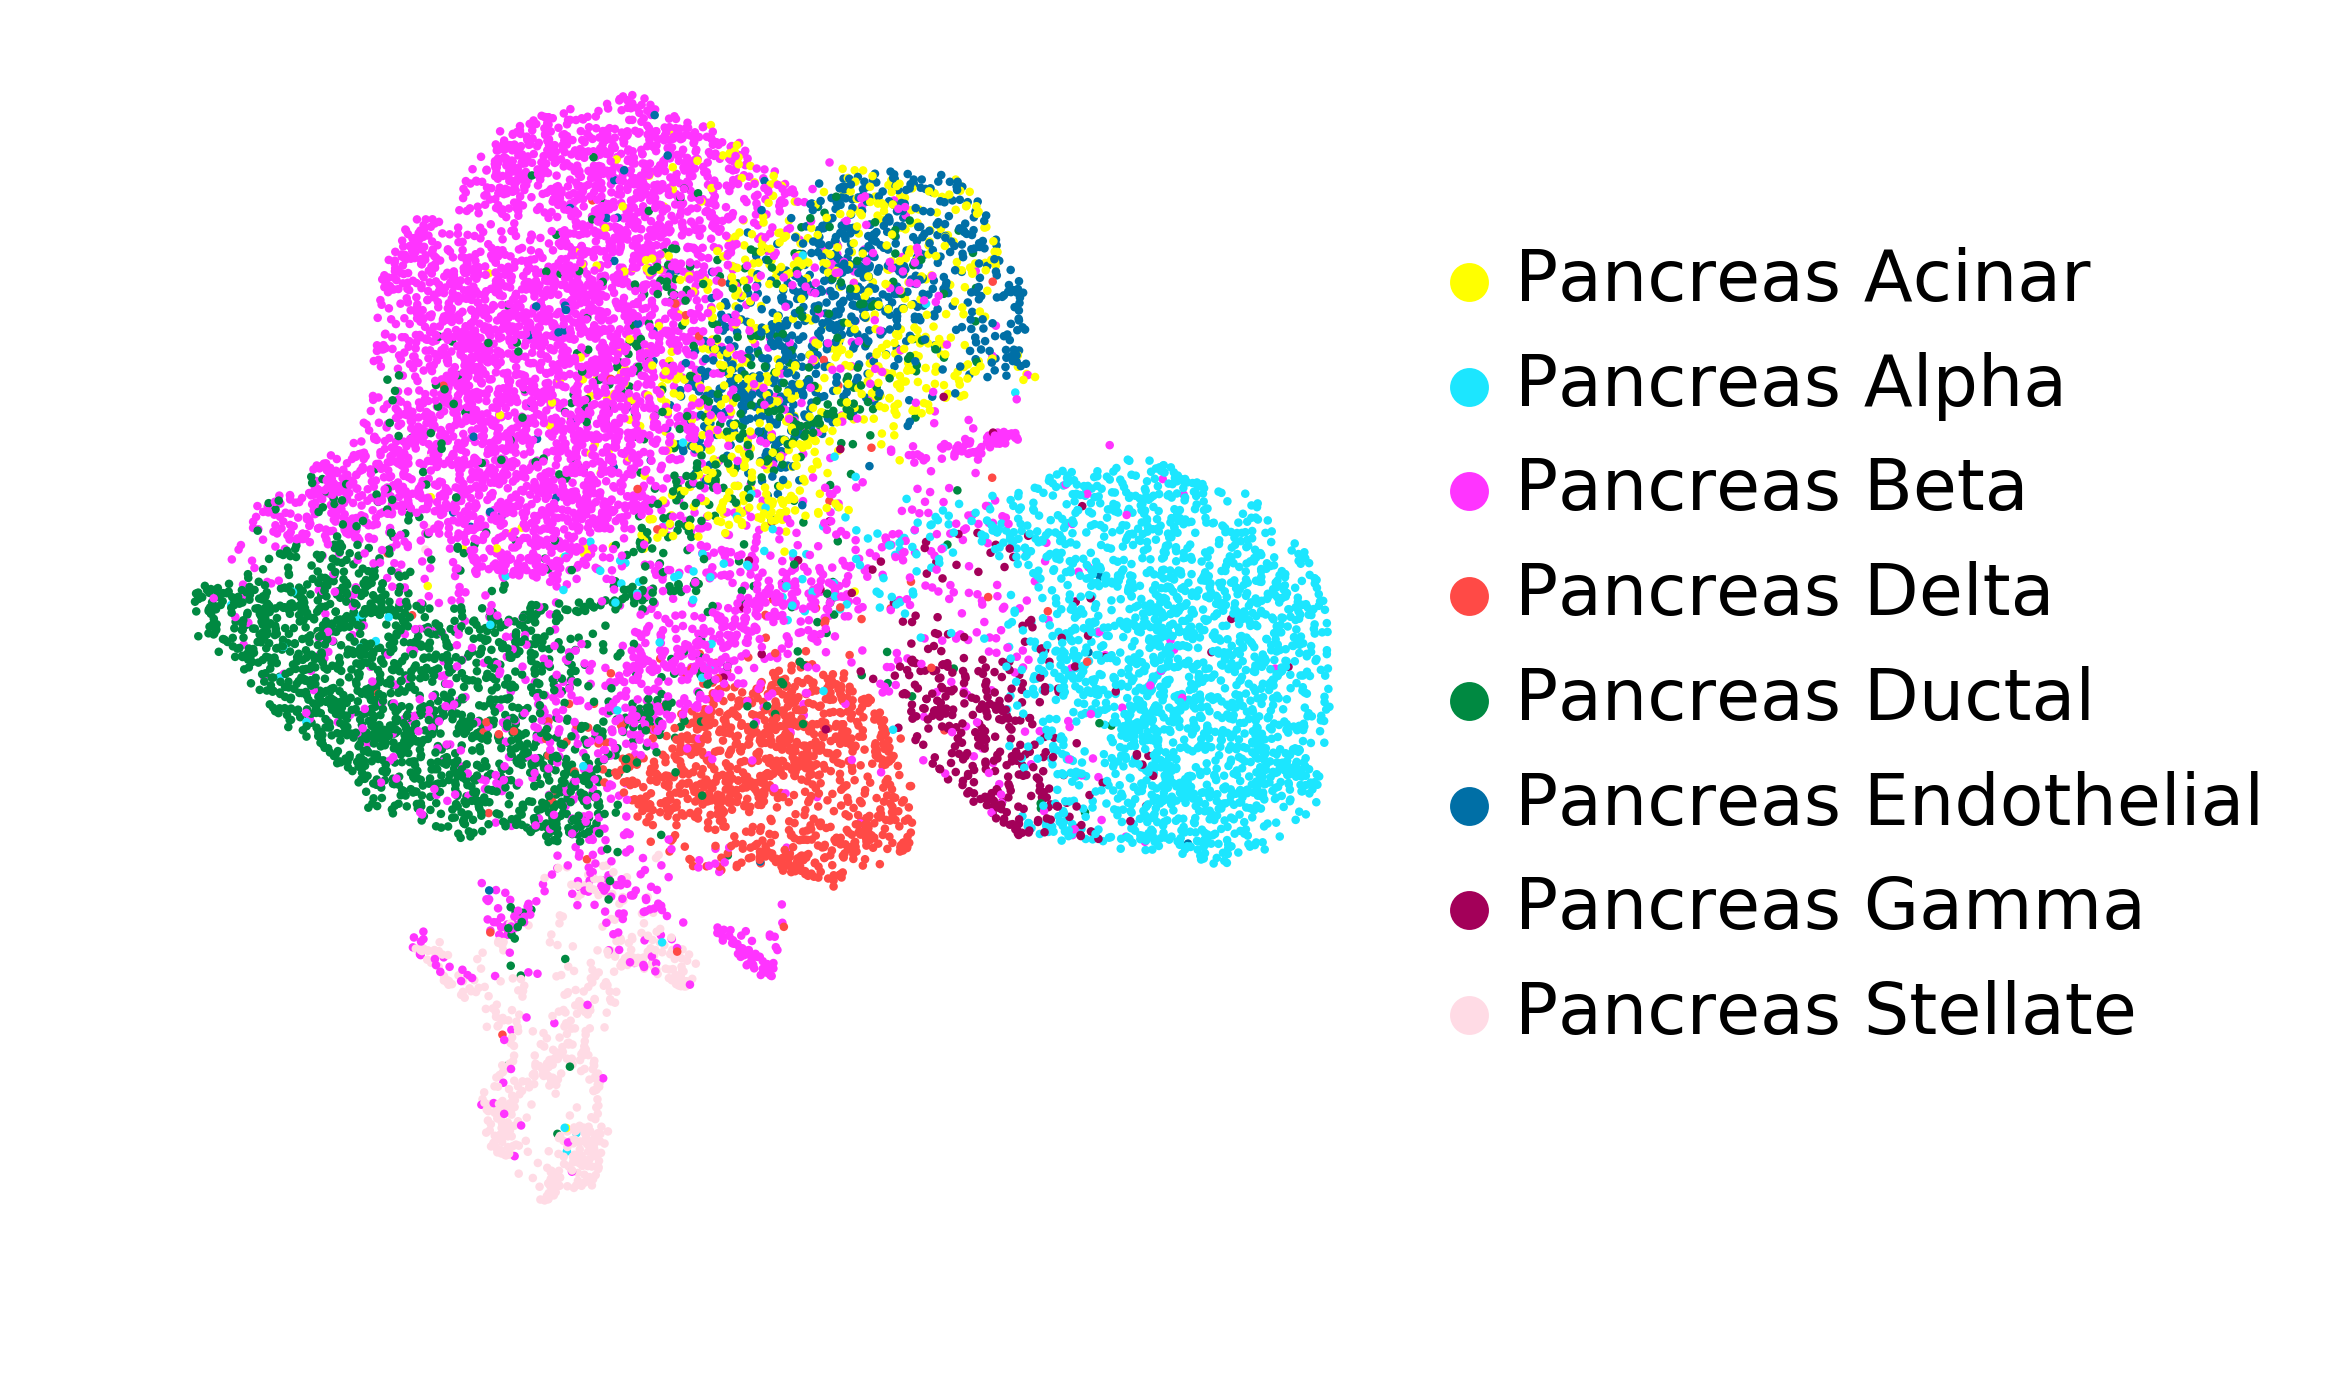

In [51]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_all_after.pdf", palette=sc.pl.palettes.godsnot_102)